# 05. Modelling and evaluation

## Objectives

The purpose of this notebook is to train, evaluate, and interpret machine learning models that predict **CEFR levels** based on learners’ engineered features. Specifically, we aim to:

- Train classification models using the processed dataset (numeric + encoded categorical features).  
- Compare performance across multiple algorithms (e.g., Logistic Regression, Random Forest, Gradient Boosting).  
- Evaluate models using accuracy, precision, recall, F1-score, and confusion matrices to assess reliability.  
- Apply hyperparameter tuning and model refinement to improve predictive performance.  
- Select the best-performing model for deployment and integration into a personalized recommendation system.  
- Save the trained model and evaluation results for reproducibility and downstream use.  

## Inputs

- **Processed dataset**: `data/processed/features.csv`  
  - Contains engineered features (e.g., strongest/weakest skill, skill variance, learning profile, relative differences).  
  - Raw scores have been dropped to prevent data leakage.  
- **Feature matrix (X)**: Scaled numeric features + encoded categorical engineered features.  
- **Target vector (y)**: Encoded CEFR levels (A1–C2).  

## Outputs

- Baseline and advanced trained models.  
- Evaluation metrics (accuracy, precision, recall, F1-score, confusion matrix).  
- Visualizations of model performance and class distribution.  
- Final selected model, serialized (e.g., `model.joblib`) for reuse.  
- Documentation of why the chosen model best supports the **business goal** of automatic learner placement and personalized recommendations.  

## Additional Information

This stage directly addresses the **business requirement**: predicting learners’ CEFR levels to enable **automatic placement** and **tailored learning recommendations**.  
Following the EDA and Feature Engineering steps, only engineered features are used to ensure models generalize fairly without memorizing exam scores.  
By systematically comparing models, tuning hyperparameters, and interpreting feature impacts, we ensure predictions are **accurate, reliable, and explainable** — making them suitable for real-world integration into an adaptive learning platform.  

---

# Project Directory Structure

## Change working directory

We need to change the working directory from its current folder to the folder the code of this project is currently located

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\husse\\OneDrive\\Projects\\lang-level-pred\\jupyter_notebooks'

In [2]:
from pathlib import Path

# swtich to project root directory
project_root = Path.cwd().parent
os.chdir(project_root)
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\husse\OneDrive\Projects\lang-level-pred


---

# Data loading
This code block imports fundamental Python libraries for data analysis and visualization and checks their versions

- pandas: For data manipulation and analysis
- numpy: For numerical computations
- matplotlib: For creating visualizations and plots
- seaborn: creating attractive and informative statistical graphics from datasets

The version checks help ensure:
- Code compatibility across different environments
- Reproducibility of analysis
- Easy debugging of version-specific issues

In [3]:
# Import data analysis tools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print(f"pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

pandas version: 2.3.1
NumPy version: 2.3.1
matplotlib version: 3.10.5
seaborn version: 0.13.2


### List Files and Folders
- This code shows what files and folders are in our data/clean folder and what folder we are currently in. 

In [5]:
import os
from pathlib import Path

dataset_dir = Path("data/processed")
print(f"[INFO] Files/folders available in {dataset_dir}:")
os.listdir(dataset_dir)

[INFO] Files/folders available in data\processed:


['features.csv', 'target.csv']

## Load Processed Data

In this step, we will load the processed dataset that was prepared in the Feature Engineering Notebook.  
The data has been saved in two separate files:

- `features.csv` → contains the engineered and scaled features.  
- `target.csv` → contains the encoded CEFR levels.  

We will:
- Load both files.  
- Inspect their structure (rows, columns, datatypes).  
- Confirm they align correctly (same number of rows).  
- Prepare them as `X` (features) and `y` (target) for model training.    

In [177]:
import pandas as pd

# Load processed features and target
X = pd.read_csv("data/processed/features.csv")
y = pd.read_csv("data/processed/target.csv").squeeze()  # convert to Series

# ✅ Drop avg_score from features
if "avg_score" in X.columns:
    X = X.drop(columns=["avg_score"])

# Inspect shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Preview
print("\nFeature columns:\n", X.columns.tolist())
print("\nTarget preview:\n", y.head())

# Validate alignment
assert X.shape[0] == y.shape[0], "❌ Row mismatch between features and target!"
print("✅ Features and target aligned correctly.")

Features shape: (1004, 14)
Target shape: (1004,)

Feature columns:
 ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'strength_weakness_gap', 'learning_profile', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant', 'speaking_level', 'reading_level', 'listening_level', 'writing_level']

Target preview:
 0    0
1    4
2    2
3    2
4    3
Name: cefr_encoded, dtype: int64
✅ Features and target aligned correctly.


---

## 1. Define Features and Target

Now that we have successfully loaded the processed dataset, we need to separate it into:

- **X (features):** all engineered and scaled variables used by the model to make predictions.  
- **y (target):** the encoded CEFR levels that the model will learn to predict.  

We will confirm that both `X` and `y` are correctly structured and aligned before proceeding to train/test splitting.

In [178]:
# Confirm feature matrix (X) and target vector (y)

print("Feature matrix (X):")
print(X.head())

print("\nTarget vector (y):")
print(y.head())

print("\nShapes:")
print("X:", X.shape)
print("y:", y.shape)

Feature matrix (X):
  strongest_skill weakest_skill second_weakest_skill  strength_weakness_gap  \
0         reading      speaking            listening               1.427690   
1        speaking       writing            listening              -1.225282   
2         reading       writing             speaking               0.101204   
3        speaking     listening            listening               0.101204   
4       listening       reading             speaking               0.631798   

     learning_profile  speaking_minus_avg  reading_minus_avg  \
0  Uneven Development           -2.069500           1.751171   
1            Balanced            0.609820           0.058795   
2            Balanced            0.197617           0.735745   
3            Balanced            1.502926           0.397270   
4            Balanced           -0.077185          -1.430496   

   listening_minus_avg  writing_minus_avg  productive_dominant speaking_level  \
0            -0.421848           0.7207

## 2. Train/Test Split with One-Hot Encoding

In this step, we:

- Split the dataset into **training** and **testing** sets using stratified sampling to preserve the CEFR class distribution.  
- Identified categorical engineered features:  
  - `strongest_skill`  
  - `weakest_skill`  
  - `second_weakest_skill`  
  - `learning_profile`  
- Identified numeric engineered features:  
  - `skill_std`  
  - `strength_weakness_gap`  
  - `productive_receptive_ratio`  
  - `speaking_minus_avg`  
  - `reading_minus_avg`  
  - `listening_minus_avg`  
  - `writing_minus_avg`  
  - `speaking_to_reading`  
  - `writing_to_listening`  
- Applied **One-Hot Encoding (OHE)** to categorical variables (dropping the first category to avoid multicollinearity).  
- Kept numeric features as-is (passthrough).  
- Verified dataset sizes before and after preprocessing. 

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numeric features
categorical_features = ["strongest_skill", "weakest_skill", "second_weakest_skill", "learning_profile", "reading_level", "listening_level", "speaking_level", "writing_level"]
numeric_features = [col for col in X.columns if col not in categorical_features]

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)

# Define preprocessing: One-Hot Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

# Split the dataset (stratify ensures CEFR balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Fit and transform training set, transform test set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Categorical features: ['strongest_skill', 'weakest_skill', 'second_weakest_skill', 'learning_profile', 'reading_level', 'listening_level', 'speaking_level', 'writing_level']
Numeric features: ['strength_weakness_gap', 'speaking_minus_avg', 'reading_minus_avg', 'listening_minus_avg', 'writing_minus_avg', 'productive_dominant']
Training set size: (803, 14)
Test set size: (201, 14)
Processed training set shape: (803, 24)
Processed test set shape: (201, 24)


## 3. Model Training (Baseline)

In this step, we will train an initial **baseline machine learning model** to predict the CEFR level.

- **Why Logistic Regression?**  
  Logistic Regression is a simple, interpretable classifier that works well as a starting point for multi-class classification. It provides a benchmark for accuracy and helps us understand whether more complex models are needed.

- **Process:**
  1. Use the preprocessed feature set (`X_train_processed`, `X_test_processed`).
  2. Train a **Logistic Regression model** with multi-class handling (`multinomial`).
  3. Evaluate performance on the test set using:
     - Accuracy
     - Classification report (precision, recall, F1-score per class)
     - Confusion matrix (to visualize misclassifications)

This baseline performance will serve as a reference point for future, more advanced models.

✅ Logistic Regression Baseline Results
Accuracy: 0.7960199004975125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.71      0.83        42
           3       0.83      0.79      0.81        38
           4       0.38      0.32      0.34        19
           5       0.45      0.62      0.53        16

    accuracy                           0.80       201
   macro avg       0.74      0.73      0.73       201
weighted avg       0.82      0.80      0.80       201



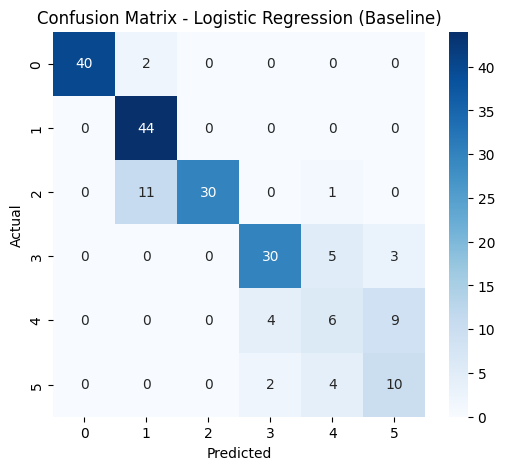

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


# Build pipeline: scaling + logistic regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False to work with sparse data from OneHotEncoder
    ("log_reg", LogisticRegression(solver="lbfgs", max_iter=2000, random_state=42))
])

# Train model
log_reg_pipeline.fit(X_train_processed, y_train)

# Predictions
y_pred = log_reg_pipeline.predict(X_test_processed)

# Evaluation
print("✅ Logistic Regression Baseline Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=log_reg_pipeline.named_steps["log_reg"].classes_, 
            yticklabels=log_reg_pipeline.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Baseline)")
plt.show()

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("Logistic Regression", y_test, y_pred)


## 4. Baseline Model: Random Forest Classifier

We begin by training a **Random Forest Classifier** as one of our baseline ensemble models.  
This approach is chosen because Random Forests:  

- Handle both categorical (OHE-encoded) and numeric features effectively.  
- Are robust to non-linear relationships and feature interactions.  
- Provide built-in handling of class imbalance (via `class_weight="balanced"`).  

The pipeline includes:  
1. **Preprocessing** → one-hot encoding for categorical features and passthrough for numeric features.  
2. **Classification** → Random Forest with 200 estimators and fixed random state for reproducibility.  

We then evaluate the model using **accuracy** and a **classification report** (precision, recall, F1-score per CEFR level).  

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score


# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight="balanced"
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)

# Results
print("✅ Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("Random Forest", y_test, y_pred)

✅ Random Forest Results
Accuracy: 0.736318407960199

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       0.81      0.89      0.85        44
           2       0.84      0.76      0.80        42
           3       0.79      0.68      0.73        38
           4       0.23      0.26      0.24        19
           5       0.32      0.38      0.34        16

    accuracy                           0.74       201
   macro avg       0.66      0.65      0.66       201
weighted avg       0.75      0.74      0.74       201



## 5. Baseline Model: XGBoost Classifier  

Next, we train an **XGBoost Classifier**, a powerful gradient boosting algorithm well-suited for multi-class classification tasks like CEFR prediction.  

Key reasons for using XGBoost:  
- Captures **non-linear relationships** and complex interactions between features.  
- Often outperforms traditional models in structured/tabular data tasks.  
- Provides **regularization** to prevent overfitting.  
- Handles class imbalance effectively when tuned appropriately.  

Configuration used:  
- `n_estimators=300` → number of boosting rounds.  
- `learning_rate=0.1` → controls contribution of each tree.  
- `max_depth=6` → controls complexity of individual trees.  
- `eval_metric="mlogloss"` → multi-class log loss for robust evaluation.  

We integrate XGBoost into the pipeline with preprocessing (OHE for categorical + passthrough for numeric) and evaluate using **accuracy** and a **classification report**.  

In [190]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

print("✅ XGBoost Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Dictionary to store results
results = {}

# Example: after each model training, store metrics
# Replace clf_name with your model name string
def evaluate_and_store_results(clf_name, y_true, y_pred):
    results[clf_name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro"),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted"),
    }

evaluate_and_store_results("XGBoost", y_test, y_pred)

c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:33:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Results
Accuracy: 0.7263681592039801

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94        42
           1       0.83      0.80      0.81        44
           2       0.78      0.76      0.77        42
           3       0.74      0.66      0.69        38
           4       0.32      0.42      0.36        19
           5       0.38      0.38      0.38        16

    accuracy                           0.73       201
   macro avg       0.66      0.66      0.66       201
weighted avg       0.74      0.73      0.73       201



## 6. Hyperparameter Tuning: Logistic Regression (with Class Imbalance Handling)

While the baseline Logistic Regression model provides a useful benchmark, its performance can be further improved through **hyperparameter tuning**.  
Because the dataset shows **class imbalance across CEFR levels**, we tune both **regularization strength** and **penalty type** while considering class weighting.

Key tuning strategies:  
- **Regularization strength (`C`)** → balances underfitting (small `C`) and overfitting (large `C`).  
- **Penalty type** (`l1`, `l2`, `elasticnet`) → explores sparsity (L1), smoothness (L2), or a combination.  
- **Elastic Net mixing (`l1_ratio`)** → balances L1 and L2 penalties for better feature selection.  
- **Class weighting** (`balanced`) → addresses class imbalance by adjusting weights inversely proportional to class frequencies.  

We use **GridSearchCV** to systematically evaluate combinations of these parameters with **macro-F1 scoring**, ensuring fair performance across all classes.

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\husse\OneDrive\Projects\lang-level-pred\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best params: {'log_reg__C': 1, 'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.0, 'log_reg__penalty': 'l1'}
✅ Best CV f1_macro: 0.7051603465359206

Test Accuracy: 0.7711442786069652

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.77      1.00      0.87        44
           2       1.00      0.69      0.82        42
           3       0.90      0.68      0.78        38
           4       0.29      0.21      0.24        19
           5       0.38      0.75      0.50        16

    accuracy                           0.77       201
   macro avg       0.72      0.71      0.70       201
weighted avg       0.81      0.77      0.77       201



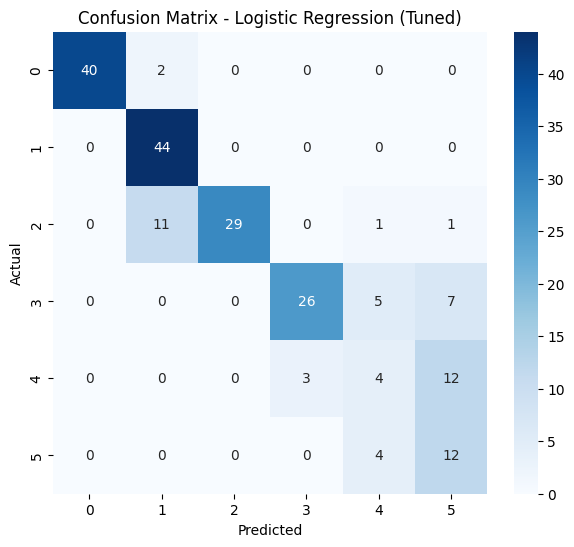

Saved tuned model to logreg_tuned_pipeline.joblib


In [ ]:
# Hyperparameter tuning for Logistic Regression (GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib   # for saving model if desired

# Pipeline: scaler (with_mean=False for sparse) + logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("log_reg", LogisticRegression(
        multi_class="multinomial",
        solver="saga",        # saga supports l1, l2, elasticnet with multinomial
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    ))
])

# Parameter grid
param_grid = {
    # regularization strength
    "log_reg__C": [0.01, 0.1, 1, 10, 100],
    # penalty types to try
    "log_reg__penalty": ["l2", "l1", "elasticnet"],
    # l1_ratio is only used if penalty='elasticnet' (ignored otherwise)
    "log_reg__l1_ratio": [0.0, 0.5],   # 0.0==l2, 0.5==mixed
    # optional: deal with class imbalance
    "log_reg__class_weight": [None, "balanced"]
}

# GridSearchCV: optimize macro-F1 (sensible for class imbalance / multiclass)
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit (this may take a while depending on dataset size)
grid.fit(X_train_processed, y_train)

# Best params & CV score
print("✅ Best params:", grid.best_params_)
print("✅ Best CV f1_macro:", grid.best_score_)

# Evaluate best estimator on the test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_processed)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.named_steps["log_reg"].classes_,
            yticklabels=best_model.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Tuned)")
plt.show()

# Optionally save the tuned pipeline
joblib.dump(best_model, "logreg_tuned_pipeline.joblib")
print("Saved tuned model to logreg_tuned_pipeline.joblib")


## 7. Cross-Validation: Logistic Regression (Out-of-Sample Evaluation)

To ensure the tuned Logistic Regression model generalizes well and is not overfitting the training data, we perform **cross-validation** using `cross_val_predict`.  
This method generates **out-of-sample predictions for each training fold**, providing a more realistic estimate of model performance compared to in-sample evaluation.

Key evaluation steps:  
- **5-Fold Cross-Validation** → training on 80% of the data and validating on 20%, repeated across folds.  
- **Macro-F1 scoring** ensures balanced performance across all CEFR levels, even in the presence of class imbalance.  
- **Confusion matrix** visualizes per-class errors and highlights where misclassifications occur.  

This step validates that the model’s performance is consistent and reliable before deployment.


📊 Cross-Fitting Results (Training Data, Out-of-Sample)
Accuracy: 0.772104607721046

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       166
           1       0.75      0.98      0.85       175
           2       0.96      0.69      0.80       166
           3       0.84      0.75      0.79       154
           4       0.44      0.45      0.44        75
           5       0.36      0.48      0.41        67

    accuracy                           0.77       803
   macro avg       0.73      0.71      0.71       803
weighted avg       0.80      0.77      0.78       803



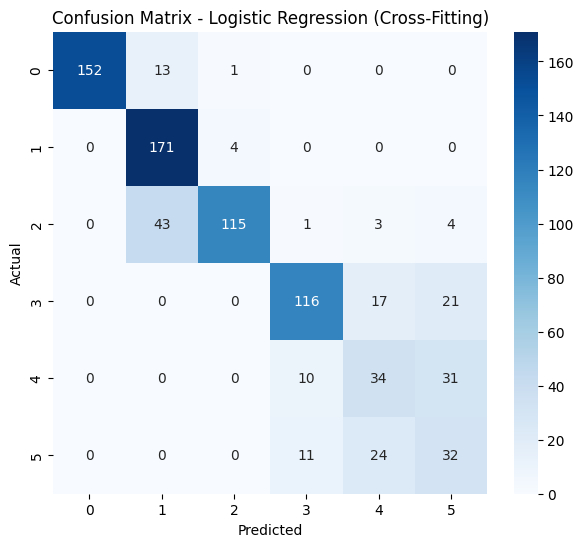

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-fitting predictions on training set
y_train_pred = cross_val_predict(best_model, X_train_processed, y_train, cv=5, n_jobs=-1)

print("\n📊 Cross-Fitting Results (Training Data, Out-of-Sample)")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.named_steps["log_reg"].classes_,
            yticklabels=best_model.named_steps["log_reg"].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Cross-Fitting)")
plt.show()